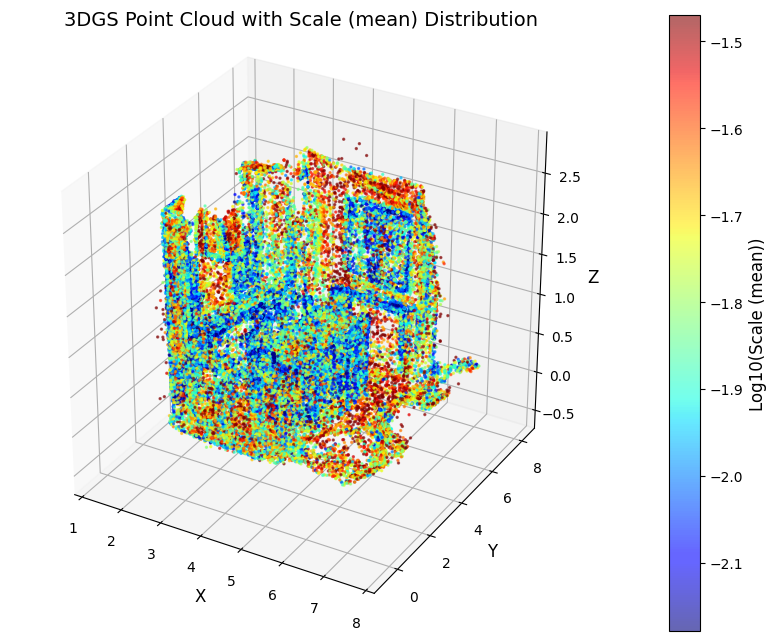

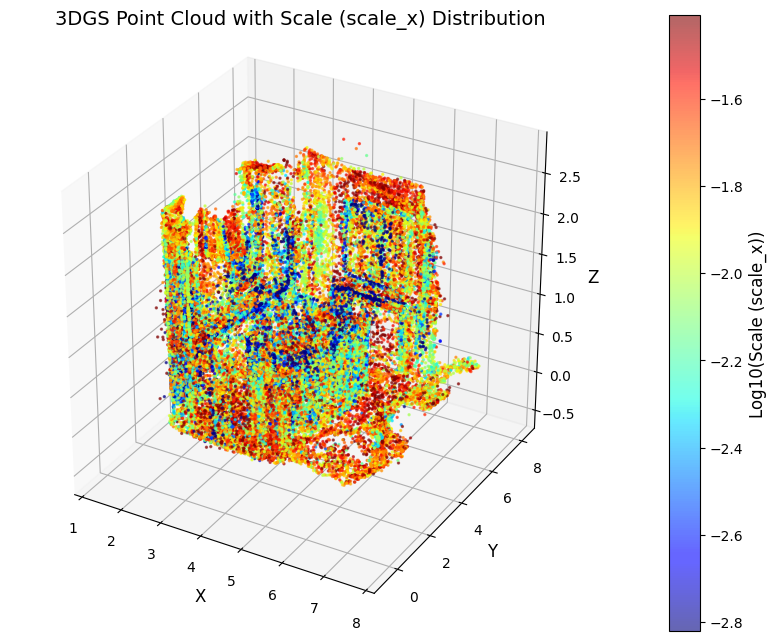

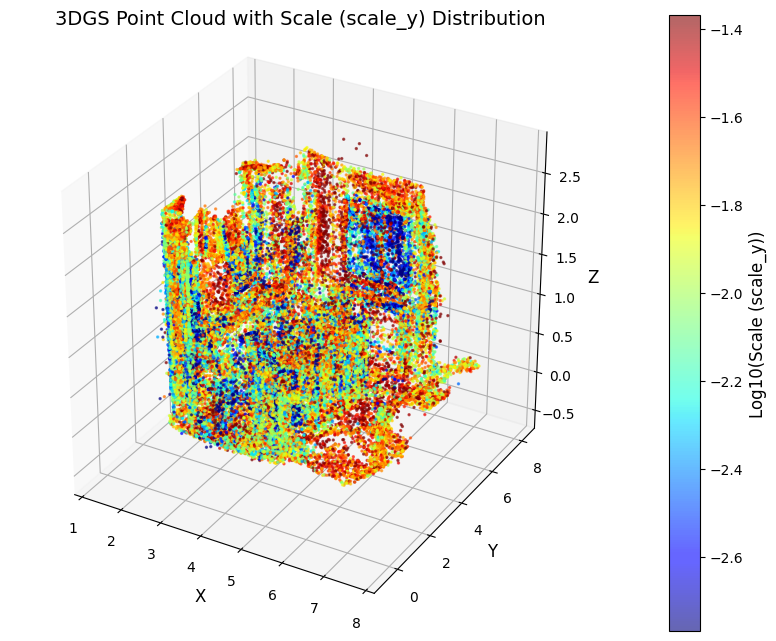

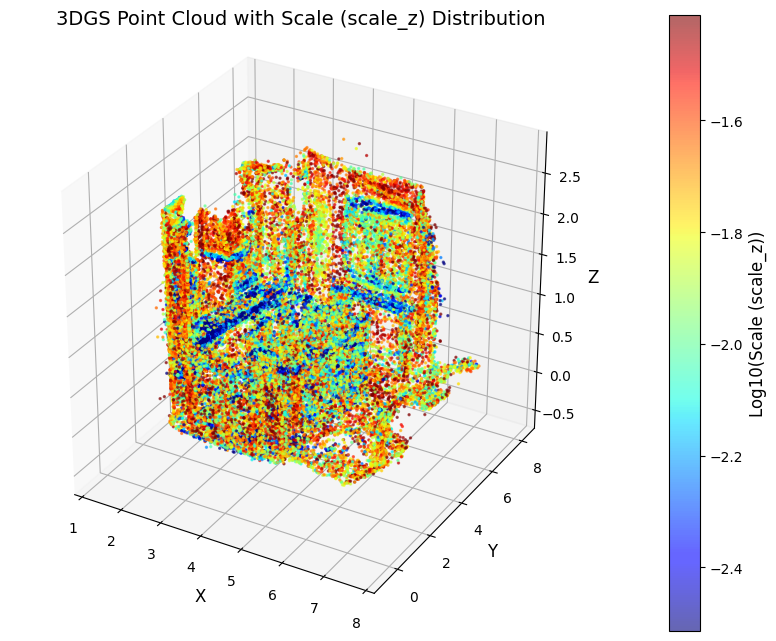

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData

import sys
sys.path.append('..')  # Add parent directory to Python path
from attribute_utils import load_pointcept_data, load_3dgs_data_with_attributes, augment_pointcept_with_3dgs_attributes, preprocessing_attr

# 3DGS 포인트 클라우드 시각화 함수
def visualize_3dgs_scale(points_3dgs, features_3dgs, scale_dim='mean', scale_range=None, point_size=1, use_log_scale=True, percentile_range=(5, 95)):
    """
    Visualize 3DGS point cloud with scale values mapped to colors.
    
    Args:
        points_3dgs (np.ndarray): 3DGS points [N, 3] (x, y, z)
        features_3dgs (np.ndarray): 3DGS attributes [N, 8] (scale_x, scale_y, scale_z, opacity, rot_w, rot_x, rot_y, rot_z)
        scale_dim (str): Which scale dimension to visualize ('mean', 'scale_x', 'scale_y', 'scale_z')
        scale_range (tuple): (min, max) range for scale color mapping. If None, use data range.
        point_size (float): Size of points in the scatter plot.
        use_log_scale (bool): Whether to use log scale for color mapping.
        percentile_range (tuple): (lower, upper) percentiles for color mapping range.
    """
    # Scale 값 추출
    scale_x = features_3dgs[:, 0]  # scale_x
    scale_y = features_3dgs[:, 1]  # scale_y
    scale_z = features_3dgs[:, 2]  # scale_z

    # Scale 값 선택
    if scale_dim == 'mean':
        scale_values = np.mean(features_3dgs[:, 0:3], axis=1)  # scale_x, scale_y, scale_z의 평균
    elif scale_dim == 'scale_x':
        scale_values = scale_x
    elif scale_dim == 'scale_y':
        scale_values = scale_y
    elif scale_dim == 'scale_z':
        scale_values = scale_z
    else:
        raise ValueError("scale_dim must be one of 'mean', 'scale_x', 'scale_y', 'scale_z'")

    # Scale 값 범위 설정
    if scale_range is None:
        # 백분위수 기반 범위 설정
        scale_min = np.percentile(scale_values, percentile_range[0])
        scale_max = np.percentile(scale_values, percentile_range[1])
    else:
        scale_min, scale_max = scale_range
    scale_values_clipped = np.clip(scale_values, scale_min, scale_max)

    # 로그 스케일 적용 (옵션)
    if use_log_scale:
        # 0 이하 값 방지를 위해 작은 값을 더함
        scale_values_for_color = np.log10(scale_values_clipped + 1e-6)
        cbar_label = f'Log10(Scale ({scale_dim}))'
    else:
        scale_values_for_color = scale_values_clipped
        cbar_label = f'Scale ({scale_dim})'

    # 3D 산점도 생성
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 포인트 클라우드 시각화
    scatter = ax.scatter(
        points_3dgs[:, 0],  # x
        points_3dgs[:, 1],  # y
        points_3dgs[:, 2],  # z
        c=scale_values_for_color,  # 색상은 scale 값에 따라 매핑
        cmap='jet',               # 색상 맵 변경 (jet: 파랑 -> 빨강)
        s=point_size,             # 포인트 크기
        alpha=0.6                 # 투명도
    )

    # 색상 바 추가
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label(cbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # 축 라벨 설정
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)

    # 제목 설정
    ax.set_title(f'3DGS Point Cloud with Scale ({scale_dim}) Distribution', fontsize=14)

    # 축 비율 조정
    ax.set_box_aspect([1, 1, 1])  # x, y, z 축 비율을 동일하게 설정

    plt.show()

# 데이터 로드 및 전처리
path_3dgs = "/home/knuvi/Desktop/song/data/3dgs_scans/3dgs_output/scene0011_00/point_cloud.ply"
points_3dgs, colors_3dgs, raw_features_3dgs = load_3dgs_data_with_attributes(path_3dgs)
features_3dgs = preprocessing_attr(raw_features_3dgs, normalize_scale=True)

# 포인트 수가 너무 많으면 샘플링 (필요 시)
max_points = 50000
if len(points_3dgs) > max_points:
    indices = np.random.choice(len(points_3dgs), max_points, replace=False)
    points_3dgs = points_3dgs[indices]
    features_3dgs = features_3dgs[indices]

# Scale 시각화 (scale_x, scale_y, scale_z, mean 각각 시각화)
scale_dims = ['mean', 'scale_x', 'scale_y', 'scale_z']
for scale_dim in scale_dims:
    visualize_3dgs_scale(
        points_3dgs,
        features_3dgs,
        scale_dim=scale_dim,
        scale_range=None,  # 데이터 범위 사용 (필요 시 (2e-4, 9.2)로 설정 가능)
        point_size=2
    )

In [ ]:
# Scale-Based Pruning 함수
def prune_by_scale(points_3dgs, features_3dgs, scale_ratio, scale_metric='norm'):
    # Scale 값 추출 (이미 exp(scale)로 복원된 상태)
    scales = features_3dgs[:, 0:3]  # [N, 3] (scale_x, scale_y, scale_z)

    # Scale 크기 계산
    if scale_metric == 'norm':
        scale_magnitudes = np.linalg.norm(scales, axis=-1)
    elif scale_metric == 'mean':
        scale_magnitudes = np.mean(scales, axis=-1)
    elif scale_metric == 'max':
        scale_magnitudes = np.max(scales, axis=-1)
    elif scale_metric == 'min':
        scale_magnitudes = np.min(scales, axis=-1)
    else:
        raise ValueError("scale_metric must be one of 'norm', 'mean', 'max', 'min'")

    # Threshold 계산 (상위 scale_ratio% 제거)
    threshold = np.percentile(scale_magnitudes, 100 * (1 - scale_ratio))
    mask = scale_magnitudes <= threshold  # 큰 값 제거

    # Pruned 데이터 생성
    points_pruned = points_3dgs[mask]
    features_pruned = features_3dgs[mask]

    print(f"Scale Pruning ({scale_metric}): Pruned {np.sum(~mask)} points with scale > {threshold:.4f}, Remaining {np.sum(mask)} points")

    return points_pruned, features_pruned, mask